# Libraries

In [ ]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from PIL import ImageFilter

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.9.2
The following GPU devices are available: /device:GPU:0


In [ ]:
from pyparsing import results
solid_fill =  (50,50,50,255)
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  # if top > total_display_str_height:
  #   text_bottom = top
  # else:
  #   text_bottom = top + total_display_str_height
  # # Reverse list and print from bottom to top.
  # for display_str in display_str_list[::-1]:
  #   text_width, text_height = font.getsize(display_str)
  #   margin = np.ceil(0.05 * text_height)
  #   draw.rectangle([(left, text_bottom - text_height - 2 * margin),
  #                   (left + text_width, text_bottom)],
  #                  fill=color)
  #   draw.text((left + margin, text_bottom - text_height - margin),
  #             display_str,
  #             fill="black",
  #             font=font)
  #   text_bottom -= text_height - 2 * margin

def draw_blur_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=(),blur_strength=2):
  """Adds a bounding box to an image."""
  display_str_list=()
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  
  mask = Image.new('L', image.size, 0)
  draw = ImageDraw.Draw(mask)
  draw.rectangle([ (left, top), (right, bottom) ], fill=255)
  blurred = image.filter(ImageFilter.GaussianBlur(blur_strength))
  image.paste(blurred, mask=mask)


def draw_boxes(image, boxes, class_names, scores, filter_list, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score and (len(filter_list) == 0 or class_names[i].decode("utf-8") in filter_list):
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

def create_rounded_rectangle_mask(rectangle):
    # create mask image. all pixels set to translucent
    i = Image.new("RGBA",rectangle.size,(0,0,0,0))
    radius = 0

    # create corner
    corner = Image.new('RGBA', (radius, radius), (0, 0, 0, 0))
    draw = ImageDraw.Draw(corner)
    # added the fill = .. you only drew a line, no fill
    draw.pieslice((0, 0, radius * 2, radius * 2), 180, 270, fill = solid_fill)

    # max_x, max_y
    mx,my = rectangle.size

    # paste corner rotated as needed
    # use corners alpha channel as mask

    i.paste(corner, (0, 0), corner)
    i.paste(corner.rotate(90), (0, my - radius),corner.rotate(90))
    i.paste(corner.rotate(180), (mx - radius,   my - radius),corner.rotate(180))
    i.paste(corner.rotate(270), (mx - radius, 0),corner.rotate(270))

    # draw both inner rects
    draw = ImageDraw.Draw(i)
    draw.rectangle( [(radius,0),(mx-radius,my)],fill=solid_fill)
    draw.rectangle( [(0,radius),(mx,my-radius)],fill=solid_fill)

    return i

def draw_blur(image, boxes, class_names, scores, filter_list, max_boxes=10, min_score=0.1, blur_strength=2):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score and (len(filter_list) == 0 or class_names[i].decode("utf-8") in filter_list):
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_blur_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str], blur_strength=blur_strength)
      np.copyto(image, np.array(image_pil))
  return image

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img
def run_detector(detector, img):
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  result = detector(converted_img)
  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  return result
def createBBox(result, filter_list, img):
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=100, filter_list=filter_list)

  display_image(image_with_boxes)

def createBlur(result, filter_list, img, blur_strength):
  image_with_blur = draw_blur(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=100, filter_list=filter_list, blur_strength=blur_strength)

  display_image(image_with_blur)

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

# Blur whole body v.s face

In [ ]:
image_url = "https://image.cnbcfm.com/api/v1/image/106879090-1620300986390-gettyimages-1231751775-20210304_covid_oxford_street_quiet_001.jpeg?v=1620301179&w=929&h=523&vtcrop=y"
image_path = download_and_resize_image(image_url, 640, 480)
img = load_img(image_path)
result = run_detector(detector, img)

Image downloaded to /tmp/tmpi8jz65l2.jpg.
Found 100 objects.


## Origin Image

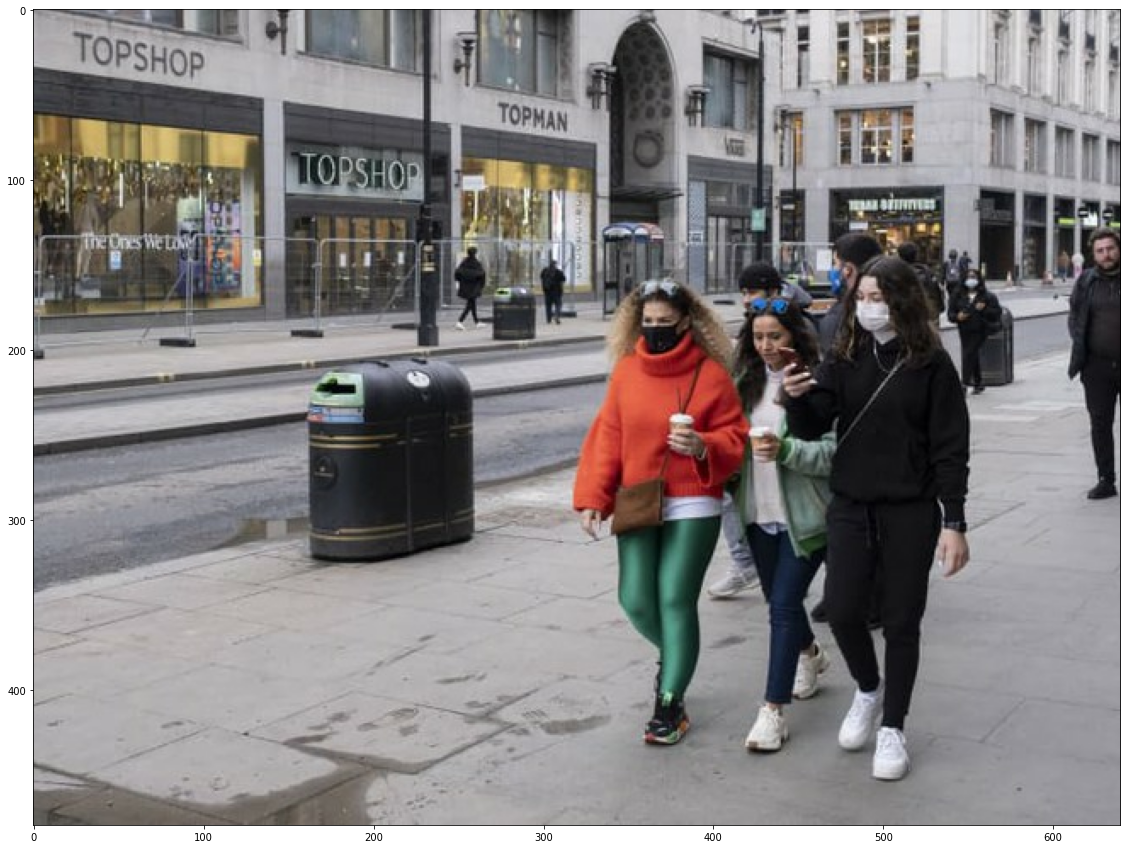

In [ ]:
display_image(img)

## Blur human faces

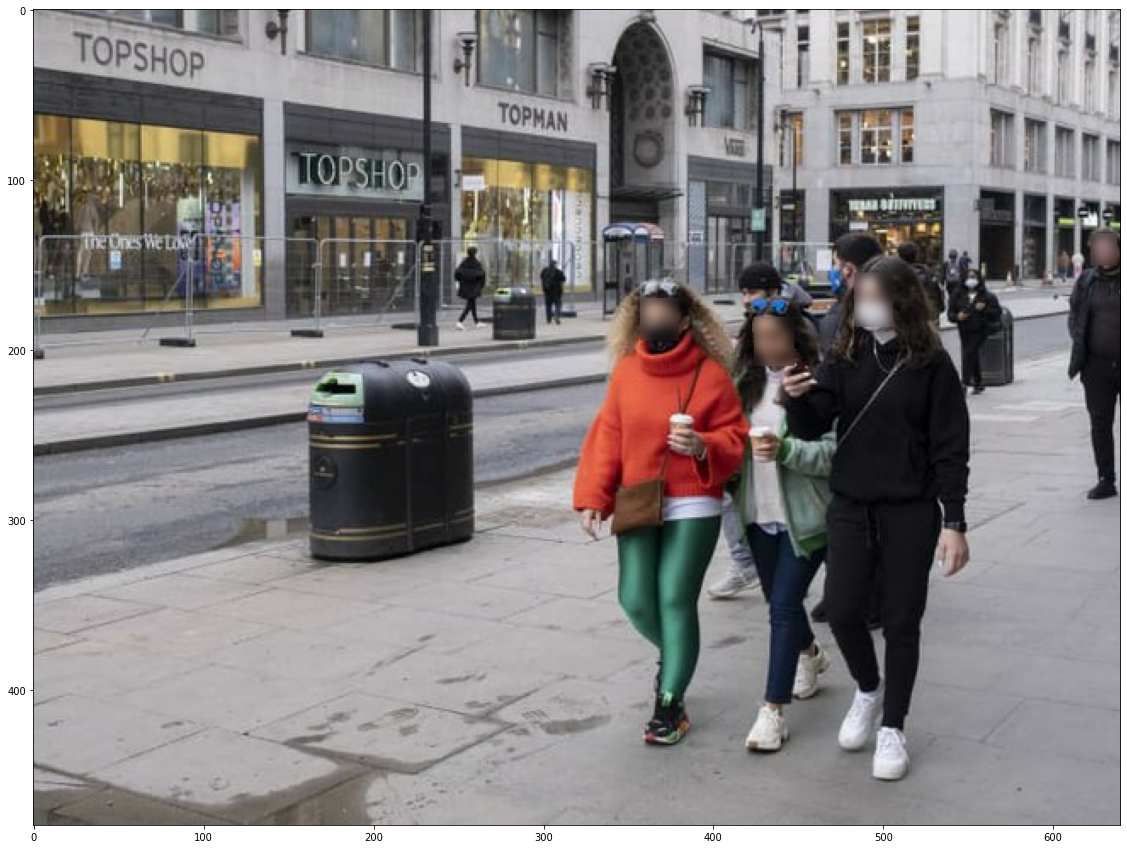

In [ ]:
createBlur(result, ["Human face"], img, blur_strength=3)

## Blur whole bodies

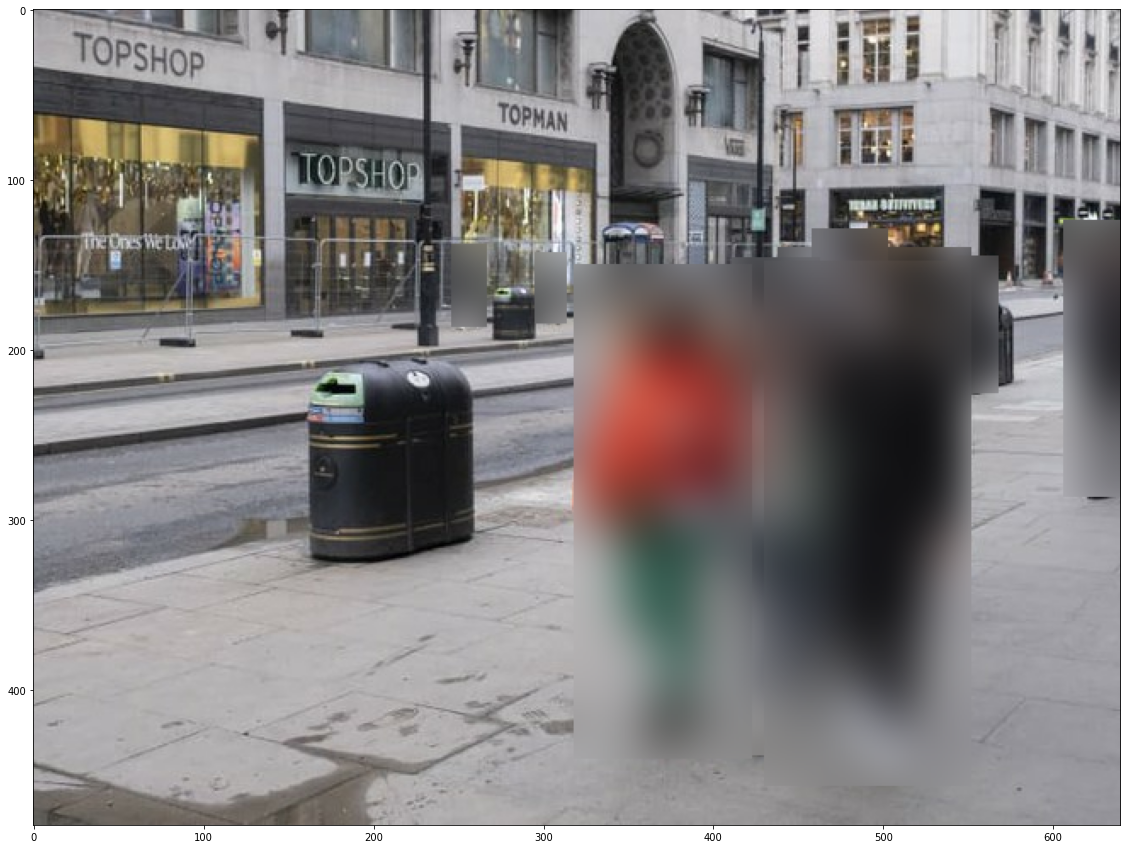

In [ ]:
createBlur(result, ["Person", "Boy", "Girl", "Man", "Woman"], img, blur_strength=10)

# Blur street sign v.s. human

In [ ]:
image_url = "https://media-exp1.licdn.com/dms/image/C4D12AQGcgpV5XN1NnQ/article-inline_image-shrink_1000_1488/0/1570519684272?e=1674086400&v=beta&t=ztVG9V9DG3A2dBgGP0AUe9rAms0qMTrQTGy8xkk1Z60"
image_path = download_and_resize_image(image_url, 640, 480)
img = load_img(image_path)
result = run_detector(detector, img)

Image downloaded to /tmp/tmprs415npa.jpg.
Found 100 objects.


## Origin Image

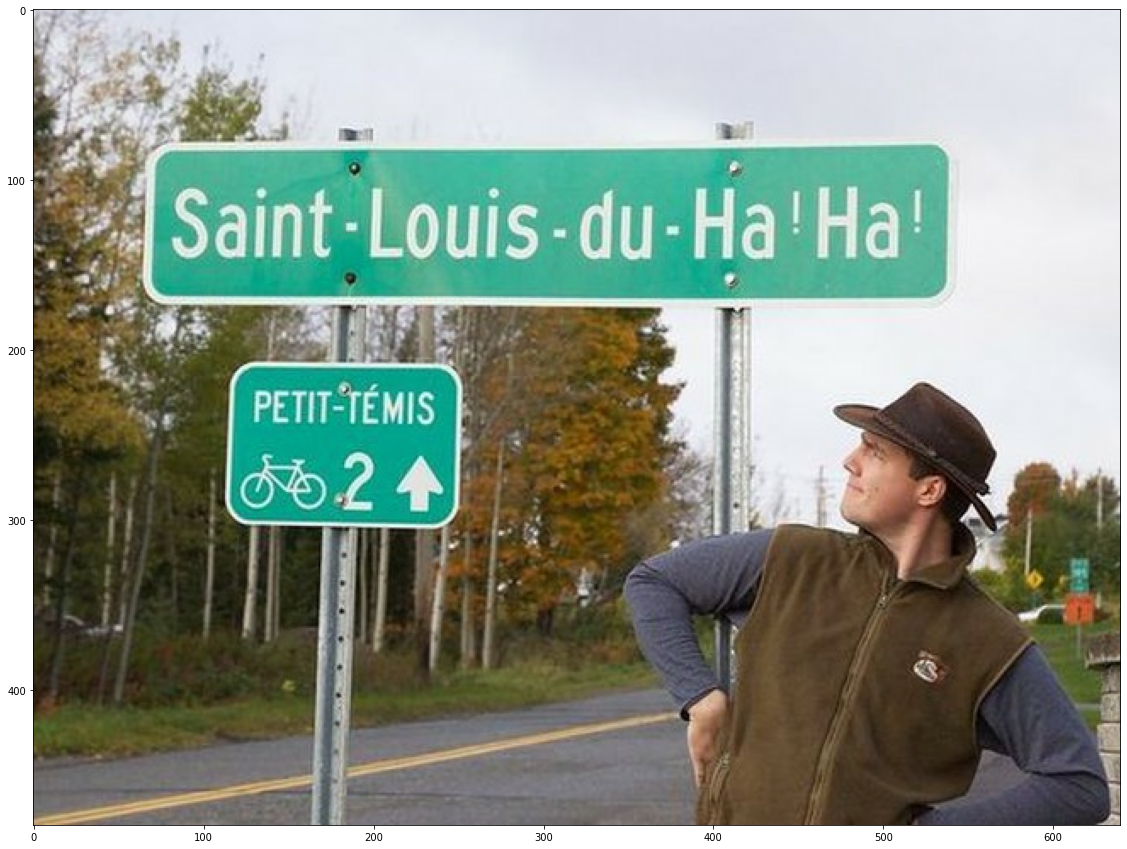

In [ ]:
display_image(img)

## If the policy asks to take out street sign

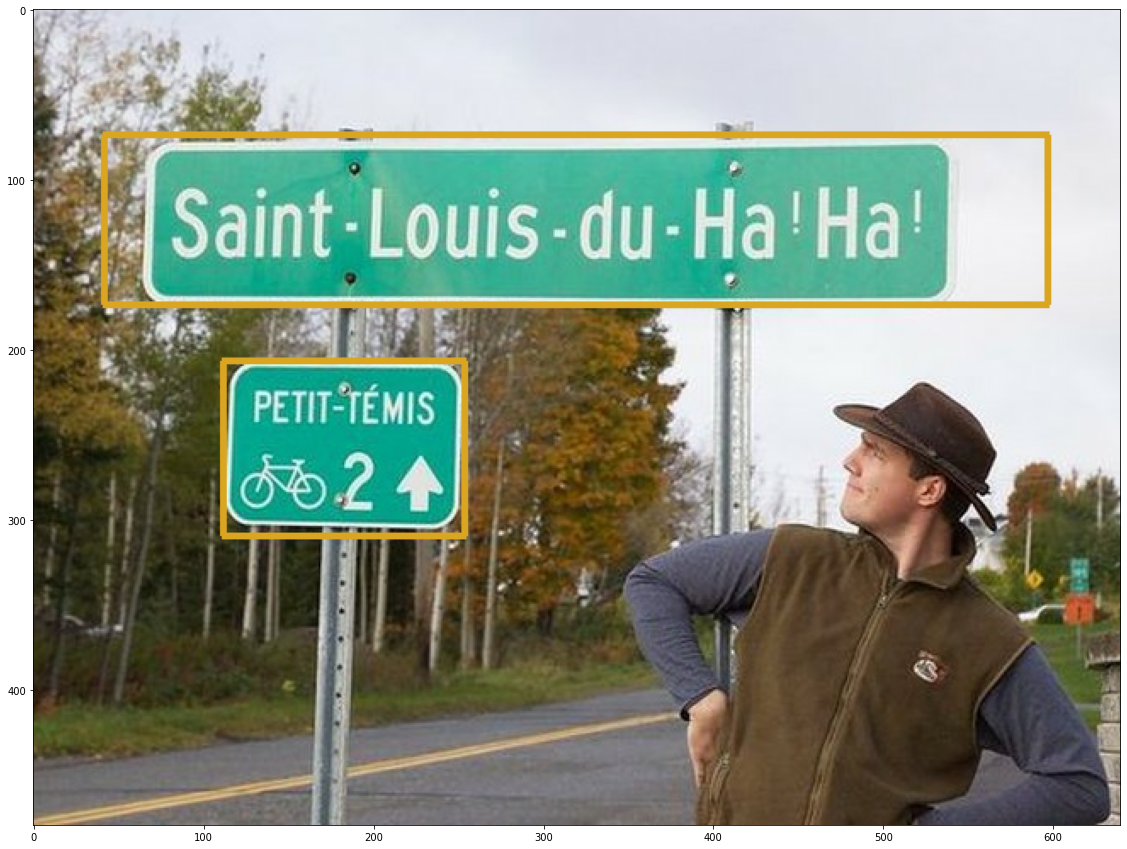

In [ ]:
createBBox(result, ["Traffic sign"], img)

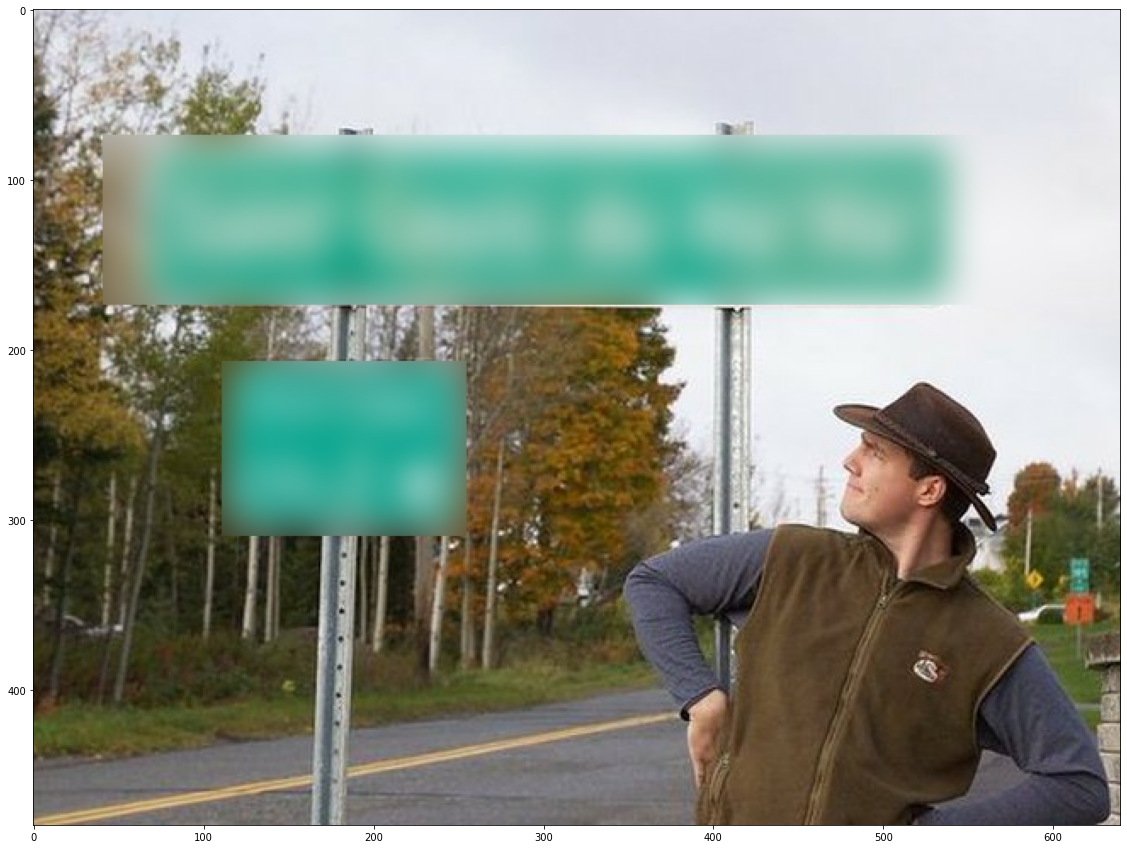

In [ ]:
createBlur(result, ["Traffic sign"], img, blur_strength=10)

## If the policy asks to take out human

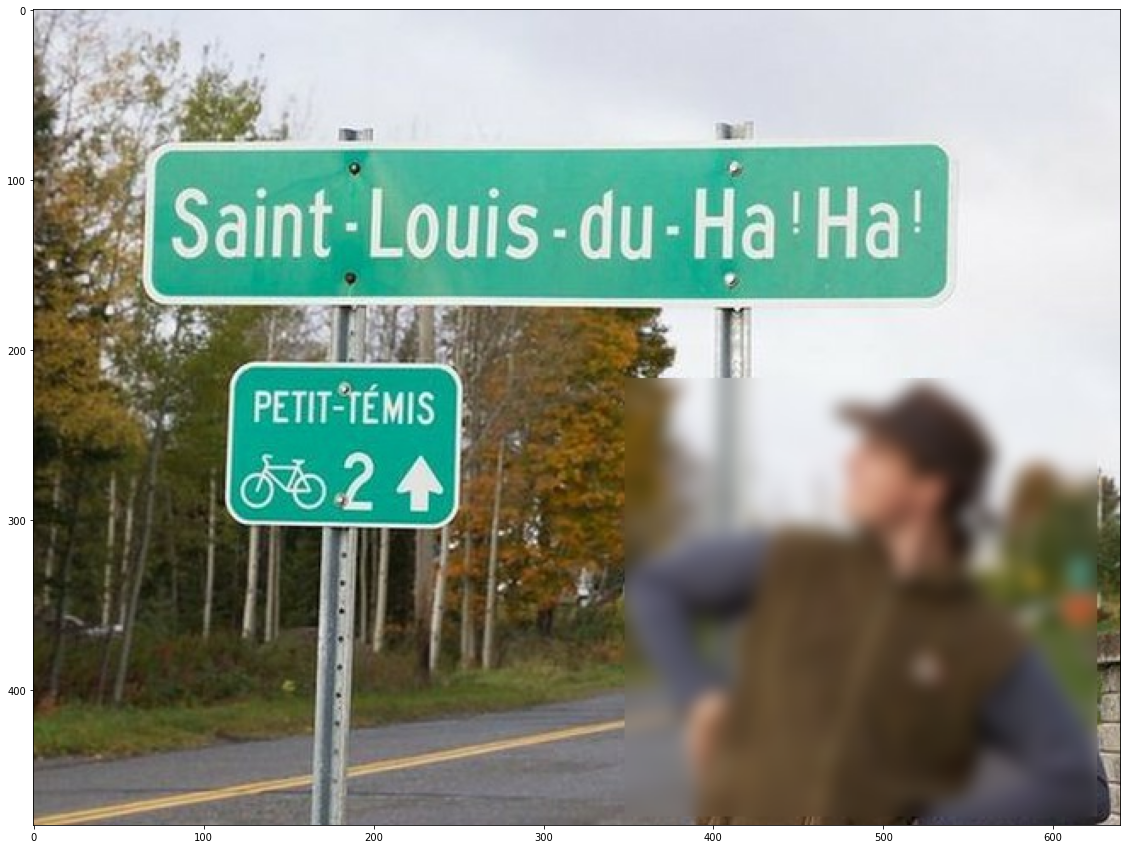

In [ ]:
createBlur(result, ["Person"], img, blur_strength=5)

## Blur Both

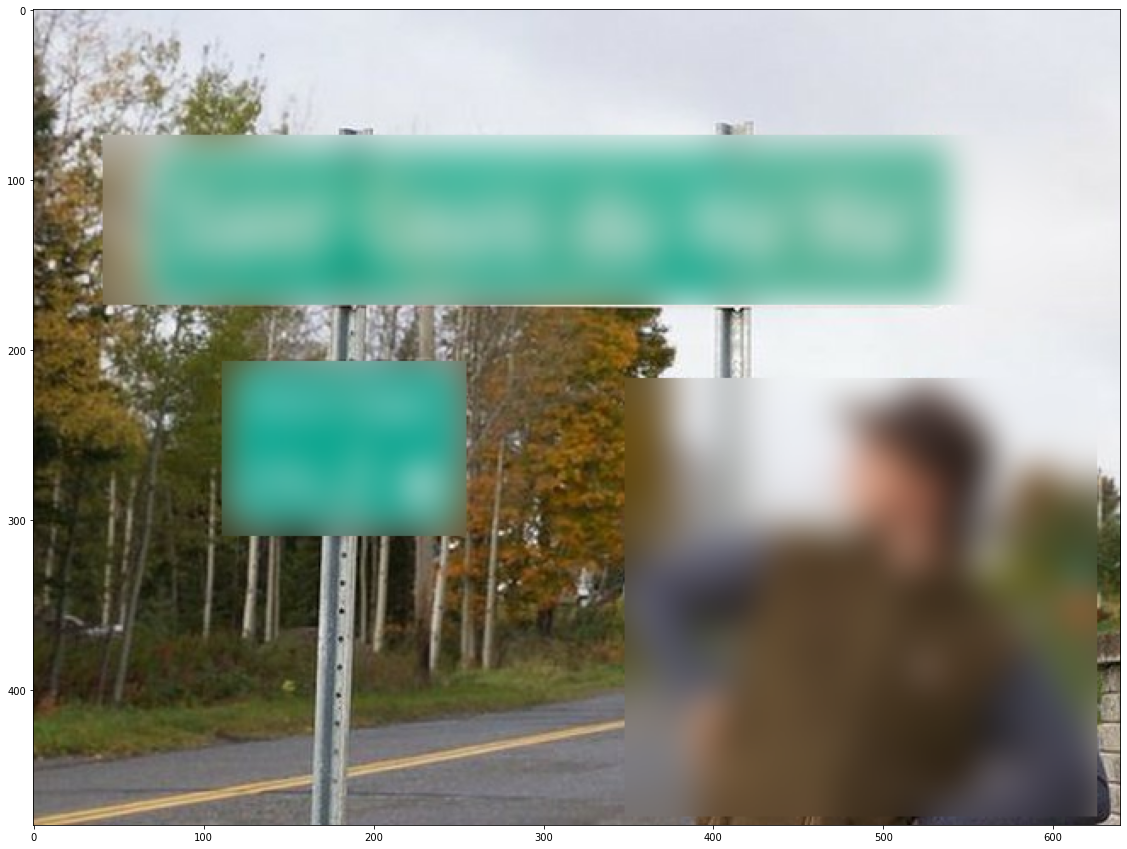

In [ ]:
createBlur(result, ["Traffic sign", "Person"], img, blur_strength=10)

In [ ]:
# import numpy as np
# np.unique(result['detection_class_entities'])